In [33]:
import glob
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import display
from skforecast.plot import set_dark_theme
from tqdm import tqdm

import sklearn
import skforecast
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from skforecast.recursive import ForecasterRecursive, ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    backtesting_forecaster,
    bayesian_search_forecaster,
    backtesting_forecaster_multiseries,
    bayesian_search_forecaster_multiseries
)
from skforecast.preprocessing import RollingFeatures, series_long_to_dict, exog_long_to_dict
from skforecast.exceptions import OneStepAheadValidationWarning

import warnings

warnings.filterwarnings("ignore", category=ResourceWarning)

colourOrangeBold = "\033[1m\033[38;5;208m"
colourReset = "\033[0m"

print(f"{colourOrangeBold}Version skforecast: {skforecast.__version__}{colourReset}")
print(f"{colourOrangeBold}Version scikit-learn: {sklearn.__version__}{colourReset}")
print(f"{colourOrangeBold}Version pandas: {pd.__version__}{colourReset}")
print(f"{colourOrangeBold}Version numpy: {np.__version__}{colourReset}")

import os
from pathlib import Path

project_root = Path().resolve()
while project_root.name != "Algothon-2025" and project_root != project_root.parent:
    project_root = project_root.parent

os.chdir(project_root)
print("Working directory set to:", os.getcwd())

set_dark_theme()

Version skforecast: 0.16.0
Version scikit-learn: 1.6.1
Version pandas: 2.2.3
Version numpy: 2.2.6
Working directory set to: /Users/jensen/Documents/Programming/Algothon-2025


Set Training, Cross Validation and Testing Splits

In [34]:
TRAIN_START = 20
TRAIN_END = 600
VAL_END = 675

Import our price data: Prices are what we are predicting

In [35]:
# PRICES DATA:
data = pd.read_csv("./sourceCode/prices.txt", sep=r'\s+', header=None)
print(f"{colourOrangeBold}Shape: {data.shape}{colourReset}")

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,38.25,69.06,62.08,31.80,63.01,28.30,36.93,43.23,42.31,67.37,...,74.39,41.30,30.05,39.53,76.07,28.62,72.03,24.02,76.03,27.50
1,38.11,69.98,62.39,31.74,62.49,28.23,37.13,42.85,41.85,68.41,...,74.69,41.70,30.18,38.93,75.71,28.47,72.11,24.04,76.05,27.54
2,37.90,69.56,62.82,31.57,62.74,28.60,36.57,42.99,41.48,69.84,...,75.14,41.14,30.09,38.17,75.56,28.48,72.54,23.76,75.66,27.55
3,37.64,69.39,63.26,31.56,61.85,28.67,37.09,43.23,41.24,70.36,...,75.24,41.38,30.08,38.24,75.35,28.59,73.75,23.97,75.71,27.74
4,37.70,69.71,64.04,31.42,62.02,28.42,37.09,42.90,41.40,69.12,...,75.33,41.69,30.34,37.85,75.21,28.55,74.32,24.01,75.77,27.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,36.49,51.34,45.11,29.37,39.73,28.69,17.89,47.71,40.70,58.56,...,75.13,46.74,39.54,32.21,75.55,30.62,85.74,16.13,81.57,31.53
746,36.30,50.95,44.66,29.32,39.85,28.59,17.84,47.31,40.32,58.05,...,75.06,47.19,39.32,32.92,75.97,30.87,85.88,15.91,80.50,31.65
747,36.58,50.80,44.25,29.17,40.01,28.97,17.76,47.01,39.97,57.61,...,74.97,47.52,39.58,33.31,76.05,30.83,86.15,15.81,80.93,31.83
748,36.43,51.19,44.02,29.11,40.01,28.54,17.69,45.68,39.86,59.06,...,75.36,48.15,39.94,32.95,75.38,30.81,86.42,15.75,80.80,31.78


Shape: (750, 50)


Add column names to prices data

In [36]:
data.index.name = 'day'
data.columns = [f"inst_{i}" for i in range(data.shape[1])]

Split data into correct splits

In [37]:
# DATA SPLITTING:
data_train = data.loc[TRAIN_START:TRAIN_END - 1].copy()
data_val   = data.loc[TRAIN_END:VAL_END - 1].copy()
data_test  = data.loc[VAL_END:].copy()

print(f"Train days      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation days : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test days       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train days      : 20 --- 599  (n=580)
Validation days : 600 --- 674  (n=75)
Test days       : 675 --- 749  (n=75)


Plot prices data for a few instruments for fun

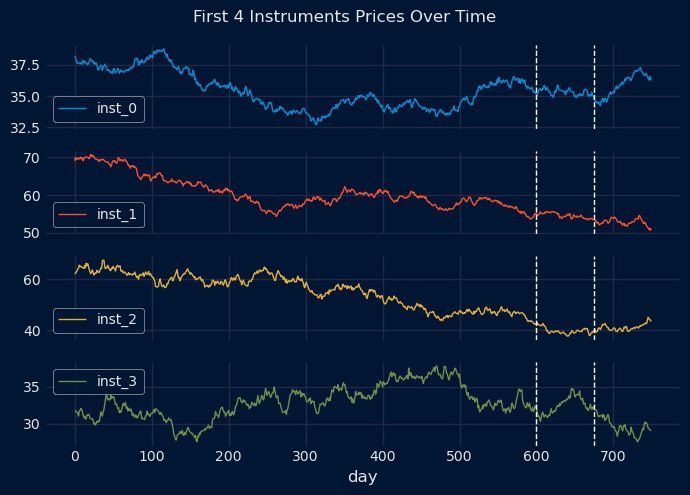

In [38]:
instrumentCount = 4

fig, axs = plt.subplots(instrumentCount, 1, figsize=(7, 5), sharex=True)
data.iloc[:, :instrumentCount].plot(
    legend=True,
    subplots=True,
    title='First 4 Instruments Prices Over Time',
    ax=axs,
    linewidth=1
)
# Add vertical lines at training and validation split
for ax in axs:
    ax.axvline(x=TRAIN_END, color='white', linestyle='--', linewidth=1)
    ax.axvline(x=VAL_END, color='white', linestyle='--', linewidth=1)
fig.tight_layout()
plt.show()

Train a forecaster that predicts prices for individual instruments for a baseline reference.

In [39]:
items = []
mse_values = []
predictions = {}

for i, item in enumerate(tqdm(data.columns)):
    # Define forecaster
    window_features = RollingFeatures(stats=['mean', 'min', 'max'], window_sizes=7)

    forecaster = ForecasterRecursive(
        regressor=HistGradientBoostingRegressor(random_state=8523),
        lags=20,
        window_features=window_features
    )

    # Backtesting forecaster
    cv = TimeSeriesFold(
        steps=1,
        initial_train_size=len(data_train) + len(data_val),
        refit=False,
    )

    metric, preds = backtesting_forecaster(
        forecaster=forecaster,
        y=data[item],
        cv=cv,
        metric='mean_squared_error',
        show_progress=False
    )

    items.append(item)
    mse_values.append(metric.at[0, 'mean_squared_error'])
    predictions[item] = preds

# Results
uni_series_mse = pd.Series(
    data=mse_values,
    index=items,
    name='uni_series_mse'
)

print(f"{colourOrangeBold}========================{colourReset}")
print(uni_series_mse.head())
print(f"{colourOrangeBold}========================{colourReset}\n\n")


100%|██████████| 50/50 [01:41<00:00,  2.03s/it]

inst_0     0.076080
inst_1     2.329248
inst_2     1.341477
inst_3     0.198996
inst_4    37.198736
Name: uni_series_mse, dtype: float64




Train a global / multi time series predictor that takes into account instrument correlation (Evaluated with the same backtester as the single instrument predictor):

In [40]:
items = list(data.columns)

# Define forecaster
window_features = RollingFeatures(stats=['mean', 'min', 'max'], window_sizes=14)
forecaster_ms = ForecasterRecursiveMultiSeries(
    regressor           =GradientBoostingRegressor(random_state=8523), # ~ 20 seconds
    # regressor           =HistGradientBoostingRegressor(random_state=8523), # Much quicker, slightly less accurate, nan safe
    lags                =20,
    encoding            ='ordinal',
    transformer_series  =StandardScaler(),
    window_features     =window_features,
)

# Backtesting forecaster for all items
cv = TimeSeriesFold(
    initial_train_size  =len(data_train) + len(data_val),
    steps               =1,   # Predict 7 steps ahead
    refit               =True # Retrain at each split
)

multi_series_mse, predictions_ms = backtesting_forecaster_multiseries(
    forecaster          =forecaster_ms,
    series              =data,
    levels              =items,
    cv                  =cv,
    metric              ='mean_squared_error',
)

# Results
display(multi_series_mse.head(5))
display(predictions_ms.head(5))

predictions_ms = predictions_ms.reset_index()

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 95 times. This can take substantial amounts of time. If   │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ /Users/jensen/anaconda3/envs/Algothon-2025/lib/python3.12/site-packages/skforecast/m │
│ odel_selection/_validation.py:844                                                    │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/95 [00:00<?, ?it/s]

,levels,mean_squared_error
0,inst_0,0.025110
1,inst_1,0.113170
2,inst_2,0.254505
3,inst_3,0.123343
4,inst_4,0.141662


,level,pred
655,inst_0,35.017062
655,inst_1,54.346196
655,inst_2,40.058624
655,inst_3,34.021163
655,inst_4,46.178838


Compare the global to unique predictors:

In [41]:
multi_series_mse = multi_series_mse.set_index('levels')
multi_series_mse.columns = ['multi_series_mse']

results = pd.concat((uni_series_mse, multi_series_mse), axis=1)
results['improvement'] = results.eval('uni_series_mse - multi_series_mse')
results['improvement_(%)'] = 100 * results.eval('(uni_series_mse - multi_series_mse) / uni_series_mse')
results = results.round(2)

display(results.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d']))
display(results[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max']))


,uni_series_mse,multi_series_mse,improvement,improvement_(%)
inst_0,0.080000,0.030000,0.050000,67.000000
inst_1,2.330000,0.110000,2.220000,95.140000
inst_2,1.340000,0.250000,1.090000,81.030000
inst_3,0.200000,0.120000,0.080000,38.020000
inst_4,37.200000,0.140000,37.060000,99.620000
inst_5,0.040000,0.030000,0.010000,26.690000
inst_6,0.230000,0.060000,0.170000,73.950000
inst_7,0.730000,0.360000,0.360000,50.150000
inst_8,0.280000,0.270000,0.010000,2.800000
inst_9,2.510000,0.480000,2.030000,80.830000


,improvement,improvement_(%)
mean,1.8106,59.252
min,0.0100,2.800
max,37.0600,99.620


Using global predict:

,time,level,pred,actual
0,655,inst_0,35.017062,35.10
1,656,inst_0,35.095640,35.20
2,657,inst_0,35.212525,35.04
3,658,inst_0,35.031688,35.14
4,659,inst_0,35.146568,35.05
...,...,...,...,...
90,745,inst_0,36.494485,36.49
91,746,inst_0,36.490672,36.30
92,747,inst_0,36.286882,36.58
93,748,inst_0,36.583518,36.43


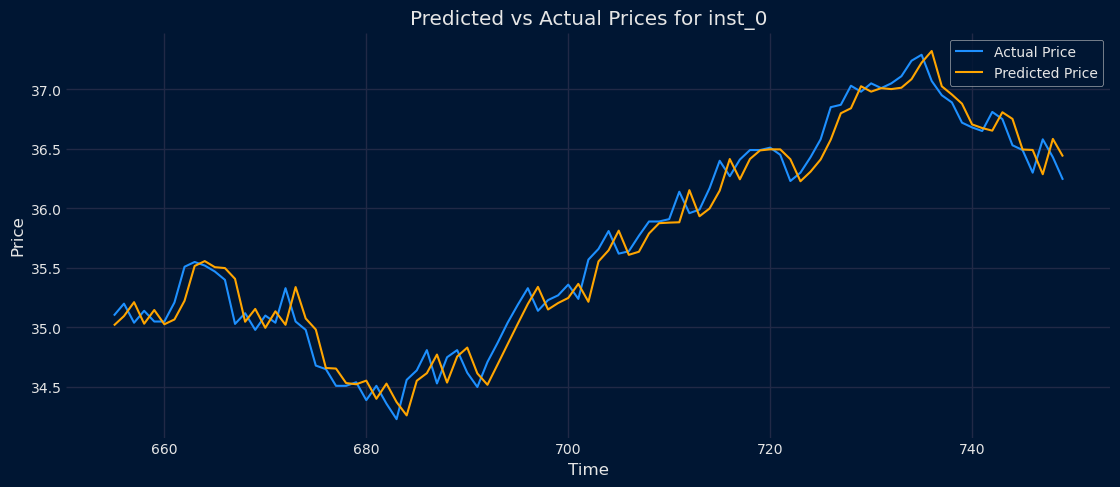

In [42]:
def plotPredictedVsActual(predictions_input, instrument):
    df_preds = predictions_input.copy().rename(columns={"index": "time"})
    df_inst_preds = df_preds[df_preds["level"] == instrument]
    days_predicted = df_inst_preds["time"]
    df_actual = data[[instrument]].copy()
    df_actual["time"] = df_actual.index
    df_actual = df_actual.rename(columns={instrument: "actual"})
    df_actual = df_actual[df_actual["time"].isin(days_predicted)]
    df_plot = df_inst_preds.merge(df_actual, on="time")
    display(df_plot)
    # Step 4: Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df_plot["time"], df_plot["actual"], label="Actual Price", color='dodgerblue')
    plt.plot(df_plot["time"], df_plot["pred"], label="Predicted Price", color='orange')
    plt.title(f"Predicted vs Actual Prices for {instrument}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


plotPredictedVsActual(predictions_ms, "inst_0")


Above looks decent but also a bit shite

**Now going to try adding more greeks to use in the model as exogenous features**


In [43]:
# Get exog features in a dictionary
greeksFilePaths = sorted(glob.glob("./greeks/greeksData/*.npy"))
feature_names = [os.path.splitext(os.path.basename(f))[0] for f in greeksFilePaths]

exog_array = np.stack([np.load(f) for f in greeksFilePaths], axis=-1)

exog_dict = {
    f"inst_{i}": pd.DataFrame(exog_array[:, i, :], columns=feature_names)
    for i in range(exog_array.shape[1])
}

print(f"{colourOrangeBold}Built exog_dict with {len(exog_dict)} instruments, each shape {exog_dict['inst_0'].shape}{colourReset}")
print("Features:", feature_names)

Built exog_dict with 50 instruments, each shape (750, 7)
Features: ['LogReturns_lookback=1_750_day_data', 'Momentum_windowSize=14_750_day_data', 'Momentum_windowSize=3_750_day_data', 'Momentum_windowSize=7_750_day_data', 'Volatility_windowSize=10_750_day_data', 'Volatility_windowSize=20_750_day_data', 'Volatility_windowSize=5_750_day_data']


Create our forecaster including these exogenous features


In [66]:
forecaster_ms_greeks = ForecasterRecursiveMultiSeries(
    regressor           = GradientBoostingRegressor(random_state=8523),
    lags                = 20,
    transformer_series  = StandardScaler(),
    transformer_exog    = StandardScaler(),  # Standardise the Greek features
)

cv = TimeSeriesFold(
    initial_train_size = len(data_train) + len(data_val),
    steps              = 1,
    refit              = True
)

# Backtest
multi_series_mse_greeks, predictions_ms_greeks = backtesting_forecaster_multiseries(
    forecaster = forecaster_ms_greeks,
    series     = data,
    exog       = exog_dict,
    levels     = list(data.columns),
    cv         = cv,
    metric     = "mean_squared_error"
)

display(multi_series_mse_greeks.head())
display(predictions_ms_greeks.head())

multi_series_mse_greeks = multi_series_mse_greeks.rename(columns={"mean_squared_error": "multi_series_mse_greeks"})
predictions_ms_greeks = predictions_ms_greeks.reset_index()
predictions_ms_greeks = predictions_ms_greeks.rename(columns={"index": "time"})

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 95 times. This can take substantial amounts of time. If   │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ /Users/jensen/anaconda3/envs/Algothon-2025/lib/python3.12/site-packages/skforecast/m │
│ odel_selection/_validation.py:844                                                    │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/95 [00:00<?, ?it/s]

,levels,mean_squared_error
0,inst_0,0.002975
1,inst_1,0.008924
2,inst_2,0.125277
3,inst_3,0.015387
4,inst_4,0.084741


,level,pred
655,inst_0,35.096051
655,inst_1,54.302063
655,inst_2,39.198674
655,inst_3,33.931266
655,inst_4,45.698133


Compare new predictions and plot new predictions vs Actual

In [67]:
multi_series_mse_greeks = multi_series_mse_greeks.set_index("levels")
# Join them
results_greeks = pd.concat((multi_series_mse, multi_series_mse_greeks), axis=1)

# Calculate improvements
results_greeks['improvement'] = results_greeks.eval('multi_series_mse - multi_series_mse_greeks')
results_greeks['improvement_(%)'] = 100 * results_greeks['improvement'] / results_greeks['multi_series_mse']
results_greeks = results_greeks.round(2)

# Display the goods
display(results_greeks.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d']))
display(results_greeks[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max']))

,multi_series_mse,multi_series_mse_greeks,improvement,improvement_(%)
levels,,,,
inst_0,0.030000,0.000000,0.020000,88.150000
inst_1,0.110000,0.010000,0.100000,92.110000
inst_2,0.250000,0.130000,0.130000,50.780000
inst_3,0.120000,0.020000,0.110000,87.520000
inst_4,0.140000,0.080000,0.060000,40.180000
inst_5,0.030000,0.000000,0.020000,87.380000
inst_6,0.060000,0.100000,-0.040000,-74.160000
inst_7,0.360000,0.010000,0.350000,96.880000
inst_8,0.270000,0.030000,0.240000,89.130000


,improvement,improvement_(%)
mean,0.201321,75.522264
min,-0.040000,-74.160000
max,1.610000,97.280000


,time,level,pred,actual
0,655,inst_13,54.644408,54.71
1,656,inst_13,54.349418,54.45
2,657,inst_13,54.566770,54.59
3,658,inst_13,54.658187,54.66
4,659,inst_13,54.688832,54.62
...,...,...,...,...
90,745,inst_13,51.115052,51.09
91,746,inst_13,51.093854,51.08
92,747,inst_13,51.149572,51.15
93,748,inst_13,51.602059,51.51


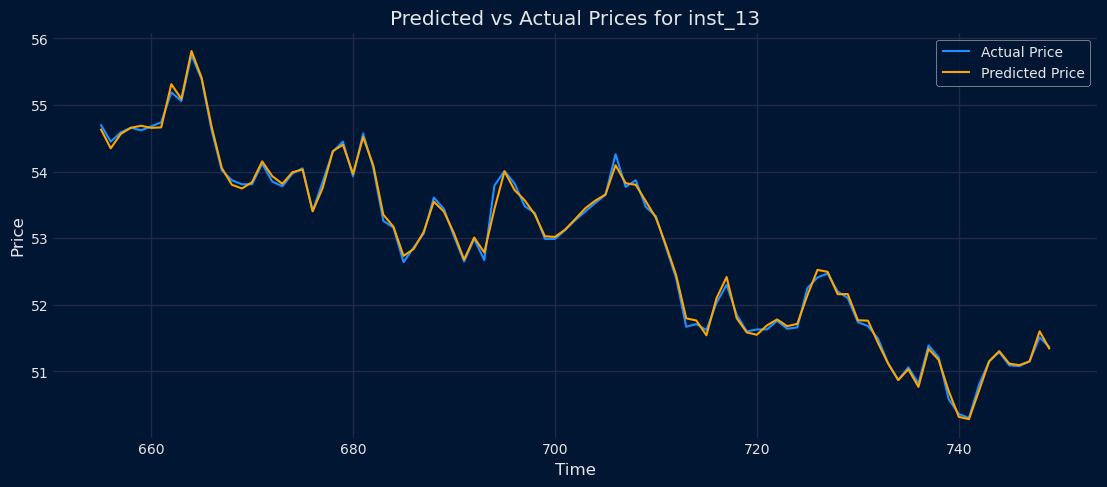

In [70]:
plotPredictedVsActual(predictions_ms_greeks, "inst_0")

# Now to try and predict log returns instead of prices:

In [105]:
logReturns_np = np.load("./greeks/greeksData/LogReturns_lookback=1_750_day_data.npy")
logReturns = pd.DataFrame(logReturns_np)

logReturns.columns = [f"inst_{i}" for i in range(logReturns.shape[1])]

print(f"{colourOrangeBold}Log returns shape = {colourReset}{logReturns.shape}")

Log returns shape = (750, 50)


Create exogenous data (now without log returns and with prices)

In [106]:
greeksFilePaths = sorted(glob.glob("./greeks/greeksData/*.npy"))
greeksFilePaths = [f for f in greeksFilePaths if "LogReturns" not in f]

feature_names = [os.path.splitext(os.path.basename(f))[0] for f in greeksFilePaths]

exog_array = np.stack([np.load(f) for f in greeksFilePaths], axis=-1)  # shape = (750, 50, num_features)

price_data = data
price_array = price_data.to_numpy()

exog_array_with_price = np.concatenate(
    [exog_array, price_array[:, :, np.newaxis]],  # add price as last feature
    axis=-1
)
feature_names.append("price")

exog_dict_for_logReturns = {
    f"inst_{i}": pd.DataFrame(exog_array_with_price[:, i, :], columns=feature_names)
    for i in range(exog_array.shape[1])
}

print(f"{colourOrangeBold}Built exog_dict_for_logReturns with {len(exog_dict_for_logReturns)} instruments, each shape{colourReset} {exog_dict_for_logReturns['inst_0'].shape}")
print("Features:", feature_names)


Built exog_dict_for_logReturns with 50 instruments, each shape (750, 7)
Features: ['Momentum_windowSize=14_750_day_data', 'Momentum_windowSize=3_750_day_data', 'Momentum_windowSize=7_750_day_data', 'Volatility_windowSize=10_750_day_data', 'Volatility_windowSize=20_750_day_data', 'Volatility_windowSize=5_750_day_data', 'price']


Now split our data

In [107]:
logReturns_train = data.loc[TRAIN_START:TRAIN_END - 1].copy()
logReturns_val   = data.loc[TRAIN_END:VAL_END - 1].copy()
logReturns_test  = data.loc[VAL_END:].copy()

print(f"Train days      : {logReturns_train.index.min()} --- {logReturns_train.index.max()}  (n={len(logReturns_train)})")
print(f"Validation days : {logReturns_val.index.min()} --- {logReturns_val.index.max()}  (n={len(logReturns_val)})")
print(f"Test days       : {logReturns_test.index.min()} --- {logReturns_test.index.max()}  (n={len(logReturns_test)})")

Train days      : 20 --- 599  (n=580)
Validation days : 600 --- 674  (n=75)
Test days       : 675 --- 749  (n=75)


In [108]:
exog_dict_for_logReturns["inst_0"]

,Momentum_windowSize=14_750_day_data,Momentum_windowSize=3_750_day_data,Momentum_windowSize=7_750_day_data,Volatility_windowSize=10_750_day_data,Volatility_windowSize=20_750_day_data,Volatility_windowSize=5_750_day_data,price
0,NaN,NaN,NaN,NaN,NaN,NaN,38.25
1,NaN,NaN,NaN,NaN,NaN,NaN,38.11
2,NaN,-0.009192,NaN,NaN,NaN,NaN,37.90
3,NaN,-0.016076,NaN,NaN,NaN,NaN,37.64
4,NaN,-0.010817,NaN,NaN,NaN,0.003717,37.70
...,...,...,...,...,...,...,...
745,-0.014150,-0.008731,-0.010902,0.002907,0.003061,0.004247,36.49
746,-0.020451,-0.012320,-0.011504,0.003102,0.003231,0.002484,36.30
747,-0.014385,0.001368,-0.002730,0.004479,0.003598,0.006276,36.58
748,-0.021991,-0.001646,-0.006021,0.004429,0.003683,0.005845,36.43


Now create this prediction model

In [ ]:
forecaster_ms_greeks_logReturns = ForecasterRecursiveMultiSeries(
    regressor           = GradientBoostingRegressor(random_state=8523),
    lags                = 20,
    transformer_series  = None,
    transformer_exog    = StandardScaler(),  # Standardise the Greek features
)

cv = TimeSeriesFold(
    initial_train_size = len(logReturns_train) + len(logReturns_val),
    steps              = 1,
    refit              = True
)

# Backtest
multi_series_mse_greeks_logReturns, predictions_ms_greeks_logReturns = backtesting_forecaster_multiseries(
    forecaster = forecaster_ms_greeks_logReturns,
    series     = logReturns,
    exog       = exog_dict_for_logReturns,
    levels     = list(logReturns.columns),
    cv         = cv,
    metric     = "mean_squared_error"
)

display(multi_series_mse_greeks_logReturns.head())
display(predictions_ms_greeks_logReturns.head())

multi_series_mse_greeks_logReturns = multi_series_mse_greeks_logReturns.rename(columns={"mean_squared_error": "multi_series_mse_greeks"})
predictions_ms_greeks_logReturns = predictions_ms_greeks_logReturns.reset_index()
predictions_ms_greeks_logReturns = predictions_ms_greeks_logReturns.rename(columns={"index": "time"})

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 95 times. This can take substantial amounts of time. If   │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ /Users/jensen/anaconda3/envs/Algothon-2025/lib/python3.12/site-packages/skforecast/m │
│ odel_selection/_validation.py:844                                                    │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/95 [00:00<?, ?it/s]

And now plot our predicted log returns against the actual:

In [ ]:
def plotPredictedVsActualLogReturns(predictions_input, instrument):
    df_preds = predictions_input.copy().rename(columns={"index": "time"})
    df_inst_preds = df_preds[df_preds["level"] == instrument]
    days_predicted = df_inst_preds["time"]
    df_actual = logReturns[[instrument]].copy()
    df_actual["time"] = df_actual.index
    df_actual = df_actual.rename(columns={instrument: "actual"})
    df_actual = df_actual[df_actual["time"].isin(days_predicted)]
    df_plot = df_inst_preds.merge(df_actual, on="time")
    display(df_plot)

    plt.figure(figsize=(12, 5))
    plt.plot(df_plot["time"], df_plot["actual"], label="Actual LogReturn", color='dodgerblue')
    plt.plot(df_plot["time"], df_plot["pred"], label="Predicted LogReturn", color='orange')
    plt.title(f"Predicted vs Actual LogReturns for {instrument}")
    plt.xlabel("Time")
    plt.ylabel("Log Return")
    plt.legend()
    plt.grid(True)
    plt.show()

plotPredictedVsActual(predictions_ms_greeks_logReturns, 0)

Now to plot predicted prices against actual prices: